<a href="https://colab.research.google.com/github/yashTilak1004/Pytorch-Practise/blob/main/CNN_practise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [55]:
#convert mnist images into tensor of 4 dimension
#h,w,color channel
transform = transforms.ToTensor()
#change image to tensor of 4 dimensions

#Train data}convert it to tensor
Train_data = datasets.MNIST(root = '/cnn_data',train = True,download = True,transform = transform)



In [56]:
#Test data
Test_data = datasets.MNIST(root = '/cnn_data',train = False,download = True,transform = transform)

In [57]:
Train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [58]:
 #convolutional and pooling layers

 #batch size should be small
train_load = DataLoader(Train_data,batch_size = 10,shuffle = True)
test_load = DataLoader(Test_data,batch_size = 10,shuffle = True)

In [59]:
#Define the CNN model
#2 convulotional layers
conv1 = nn.Conv2d(1,6,3,1)
#in , out(feature maps) , kernel size and stride
conv2 = nn.Conv2d(6,16,3,1)

#grab an mnist image
for i,(X_train,y_train) in enumerate(Train_data):
  break

In [60]:
for i,(X_train,y_train) in enumerate(Train_data):
  break
X_train.shape #[1,28,28]->1 image of size 28*28 pixel

torch.Size([1, 28, 28])

In [61]:
x = X_train.view(1,1,28,28)#change it into a 4d image with 1 batch 1 iamge of size 28*28

In [62]:
x = F.relu(conv1(x))
x.shape #after the layer is ran->[1,6,26,26]
# 1 is the single image
#6 is the filters
#26*26 is the image
#x =F.max_pool2d(x,2,2)#kernel size of 2 and stride of 2

torch.Size([1, 6, 26, 26])

In [63]:
x.shape#[1,6,13,13]->26*26 shrinked by 2 so 13*13
x =F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [64]:
#another convolutional layer

x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [66]:
#pooling
x = F.max_pool2d(x,2,2)
x.shape#[1,16,5,5]->round it down

torch.Size([1, 16, 5, 5])

In [75]:
#model class
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    #the connected layer
    #5,5,16 is the output given by the last pooling layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)#2x2 kernel and stride 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)

    #flatten th epooled data
    X =x.view(-1,16*5*5)#to differentiate the batch size
    #print(X.shape)

    #now go through the connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))

    return F.log_softmax(X,dim = 1)

In [76]:
#instance of our model
torch.manual_seed(32)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [77]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)#learning rate and speed are inversely proportional in CNN


In [80]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0#number of trained values that are correct
  tst_corr = 0

  for b,(X_train,Y_train) in enumerate(train_load):
    b+=1#number of batches
    y_pred = model(X_train) #this is in 2d,not flat to pass it further
    loss = criterion(y_pred,Y_train)

    predicted = torch.max(y_pred.data,1)[1] #add the number of correct predictions
    batch_corr = (predicted == Y_train).sum() #0/1

    trn_corr += batch_corr

    #optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print("Epoch:",i," ","Batch:",b," ","Loss:",loss.item())
  train_losses.append(loss)
  train_correct.append(trn_corr)

  ts_corr = 0
  #do the testing
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_load):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      ts_corr += (predicted == y_test).sum()

  loss1 = criterion(y_val,y_test)
  test_losses.append(loss1)
  test_correct.append(ts_corr)

current_time = time.time()
Total_time = current_time - start_time
print("Time took:",Total_time)

Epoch: 0   Batch: 600   Loss: 1.4779859781265259
Epoch: 0   Batch: 1200   Loss: 0.9861955642700195
Epoch: 0   Batch: 1800   Loss: 1.0625174045562744
Epoch: 0   Batch: 2400   Loss: 0.9242938756942749
Epoch: 0   Batch: 3000   Loss: 0.8206874132156372
Epoch: 0   Batch: 3600   Loss: 0.9214671850204468
Epoch: 0   Batch: 4200   Loss: 0.6976826190948486
Epoch: 0   Batch: 4800   Loss: 0.921680748462677
Epoch: 0   Batch: 5400   Loss: 0.46950215101242065
Epoch: 0   Batch: 6000   Loss: 0.46465593576431274
Epoch: 1   Batch: 600   Loss: 0.4614998400211334
Epoch: 1   Batch: 1200   Loss: 0.9212328195571899
Epoch: 1   Batch: 1800   Loss: 0.46053630113601685
Epoch: 1   Batch: 2400   Loss: 0.922718346118927
Epoch: 1   Batch: 3000   Loss: 0.4733949601650238
Epoch: 1   Batch: 3600   Loss: 0.6910584568977356
Epoch: 1   Batch: 4200   Loss: 0.23272080719470978
Epoch: 1   Batch: 4800   Loss: 0.4613497853279114
Epoch: 1   Batch: 5400   Loss: 0.4631156027317047
Epoch: 1   Batch: 6000   Loss: 0.2309027463197708


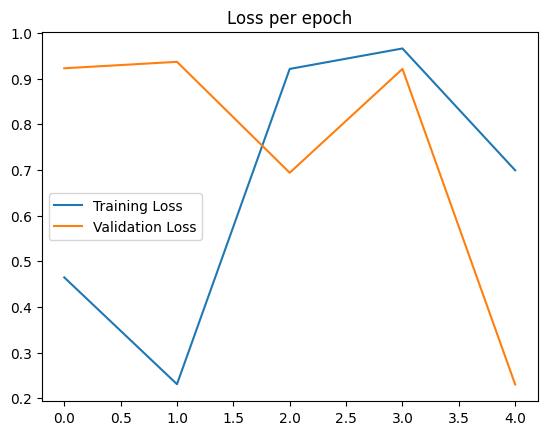

In [82]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Validation Loss")
plt.title("Loss per epoch")
plt.legend()